In [3]:
# Precompute a 1-D Green's function for a homogeneous membrane medium
import numpy as np
import os
import h5py
from math import sqrt, pi
from scipy.signal import hann
from obspy.geodetics import gps2dist_azimuth
import matplotlib.pyplot as plt

In [4]:
# set the parameters
output_location = '/Users/lermert/Desktop/Japan/green_1d/wavefield'
srcgrid = np.load('/Users/lermert/Desktop/Japan/green_1d/sourcegrid.npy')
rec_codes = ['BO.SAG..BHZ','BO.NSK..BHZ','BO.KMT..BHZ','BO.IZH..BHZ']
rec_locations = [[36.2553,133.3050],[34.3403,132.0018],[33.6782,135.4899],[34.1359,129.2066]]
v_phase = 3000.
q = 100.
rho = 3300.
Fs = 1.0


npts = 3600
# Apply a freq. domain taper to suppress high and low frequencies.
filt = [0.005,0.2]
data_quantity = 'VEL'
ntraces = len(srcgrid[0])

In [5]:
freq = np.fft.rfftfreq(2*int(npts),d=1.0/Fs)
print freq.shape
w = 2 * pi * freq
g_fd = np.zeros(freq.shape)
def green_membrane(r,plot):
    if data_quantity == 'DIS':
        fac1 = -1j*1./(rho*v_phase**2*4.)
    elif data_quantity == 'VEL':
        fac1 = w[1:]*1./(rho*v_phase**2*4.)
    fac2 = np.sqrt((2.*v_phase)/(pi*w[1:]*r))
    phase = -1j * w[1:] / v_phase * r + 1j * pi / 4.0
    decay = -(w[1:]*r)/(2.*v_phase*q)
    
    g_fd[1:] = fac1*fac2*np.exp(phase)*np.exp(decay)
    if plot:
        plt.plot(freq,np.abs(g_fd))
        plt.show()
    return g_fd

(3601,)


/Users/lermert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part


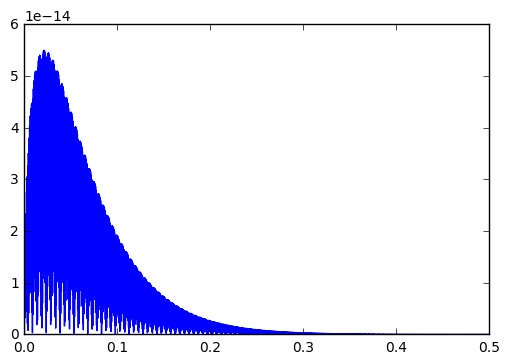

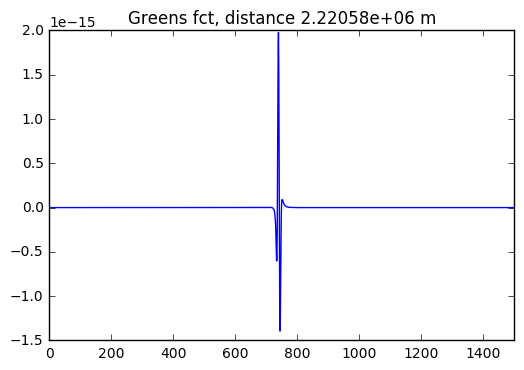

In [ ]:
for i in range(len(rec_codes)):
    if not os.path.exists(output_location):
        os.mkdir(output_location)

    station = rec_codes[i]
    lat_sta = rec_locations[i][0]
    lon_sta = rec_locations[i][1]

    # initialize the file

    f_out_name = os.path.join(output_location, station + '.h5') 
    with h5py.File(f_out_name, "w") as f_out:

        # DATASET NR 1: STATS
        stats = f_out.create_dataset('stats',data=(0,))
        stats.attrs['reference_station'] = station
        stats.attrs['data_quantity'] = data_quantity
        stats.attrs['ntraces'] = ntraces
        stats.attrs['Fs'] = Fs
        stats.attrs['nt'] = int(npts)

        # DATASET NR 2: Source grid
        sources = f_out.create_dataset('sourcegrid',data=srcgrid)

        # DATASET Nr 3: Seismograms itself
        traces = f_out.create_dataset('data',(ntraces,npts),dtype=np.float32)

        for k in range(ntraces):
            # for each location, determine the distance
            lat = srcgrid[1,k]
            lon = srcgrid[0,k]

            r = gps2dist_azimuth(lat,lon,lat_sta,lon_sta)[0]

        # evaluate the Greens fct.
            if k % 10000 == 0:
                plot = True
            else:
                plot = False
            g1 = green_membrane(r,plot)

        # apply the freq. domain taper
            taper = np.zeros(freq.shape)
            i0 = np.argmin(np.abs(freq-filt[0]))
            i1 = np.argmin(np.abs(freq-filt[1]))

            taper[i0:i1] = hann(i1-i0)

        # transform back to time domain
            g1_td = np.fft.irfft(g1)[0:3600]
            g1_td_taper = np.fft.irfft(taper*g1)[0:3600]
            if k % 30000 == 0:
                t = np.linspace(0,npts*1./Fs,npts)
                #plt.plot(t,g1_td)
                plt.plot(t,g1_td_taper)
                plt.xlim([0,1500])
                plt.title('Greens fct, distance %g m' %r)
                plt.show()


        # write the result
            traces[k,:] = g1_td_taper
            f_out.flush()

